In [1]:
import numpy as np
import pandas as pd
from datafold.pcfold import TSCDataFrame
from sklearn.model_selection import train_test_split

import helper

# Prepare data

Read, select and split data into training and test set.


#### Overview of all files:

`X_all.csv` -- raw data of all sensors between 1/1/2016 - 12/31/2019

`X_selected.csv` -- selected sensors and samples in `X_all.csv`

`X_windows_[train|test].csv` -- data in time series of length 192; 168 hour (initial condition) + 24 hours (prediction) 

`X_reconstruct_[train|test].csv` -- reconstructed data in time series of length 24 for each window in corresponding`X_windows`

`X_latent_[train|test].csv` -- diffusion map values for each window

`X_latent_interp_test.csv` -- with EDMD model interpolated diffusion map values   

`X_eigfunc_test.csv` -- complex Koopman eigenfunction values

##### Set cache

Enable to read cached csv data. All the above listed files must be available in the repository. 
If False this creates new files or overwrites the existing `.csv` files.

In [2]:
use_cache = False  

In [3]:
if use_cache:
    X = TSCDataFrame.from_csv("X_selected.csv", parse_dates=True)
else:
    X = helper.read_and_select_data("X_all.csv")
    X.to_csv("X_selected.csv")

train_time_values, test_time_values = train_test_split(
        X.index.get_level_values("time"),
        train_size=2 / 3.0,
        shuffle=False,
)

train_sensor_data = X.loc[pd.IndexSlice[:, train_time_values], :]
test_sensor_data = X.loc[pd.IndexSlice[:, test_time_values], :]

n_samples_ic = 168+1  # 168 time delays are needed for the time delay embedding +1 for the current state

train_sensor_data = helper.filter_data(
    X=train_sensor_data,
    start_time=0,
    n_samples_ic=n_samples_ic,
    min_timesteps=2 * n_samples_ic,
)

test_sensor_data = helper.filter_data(
    X=test_sensor_data,
    start_time=0,
    n_samples_ic=n_samples_ic,
    min_timesteps=2 * n_samples_ic,
)

print(f"Total n_samples: {train_sensor_data.shape[0] + test_sensor_data.shape[0]}")
print(f"Total samples train: {train_sensor_data.shape[0]}")
print(f"Total samples test: {test_sensor_data.shape[0]}")
print(f"Total time series: {train_sensor_data.n_timeseries + test_sensor_data.n_timeseries}"
)
print(f"Time series train: {train_sensor_data.n_timeseries}")
print(f"Time series test: {test_sensor_data.n_timeseries}")

Remove 1056 hours from holidays.
sensor_2_counts has 43 timeseries
sensor_2_counts has 3600000000000 nanoseconds delta_time
sensor_6_counts has 43 timeseries
sensor_6_counts has 3600000000000 nanoseconds delta_time
sensor_9_counts has 43 timeseries
sensor_9_counts has 3600000000000 nanoseconds delta_time
sensor_10_counts has 50 timeseries
sensor_10_counts has 3600000000000 nanoseconds delta_time
sensor_18_counts has 45 timeseries
sensor_18_counts has 3600000000000 nanoseconds delta_time
sensor_21_counts has 43 timeseries
sensor_21_counts has 3600000000000 nanoseconds delta_time
sensor_24_counts has 43 timeseries
sensor_24_counts has 3600000000000 nanoseconds delta_time
sensor_26_counts has 43 timeseries
sensor_26_counts has 3600000000000 nanoseconds delta_time
sensor_27_counts has 48 timeseries
sensor_27_counts has 3600000000000 nanoseconds delta_time
sensor_28_counts has 43 timeseries
sensor_28_counts has 3600000000000 nanoseconds delta_time
sensor_31_counts has 44 timeseries
sensor_3

In [4]:
test = X.to_csv()

## Plot sensor data

The blue part is the training data, red the chronologically separated test data.

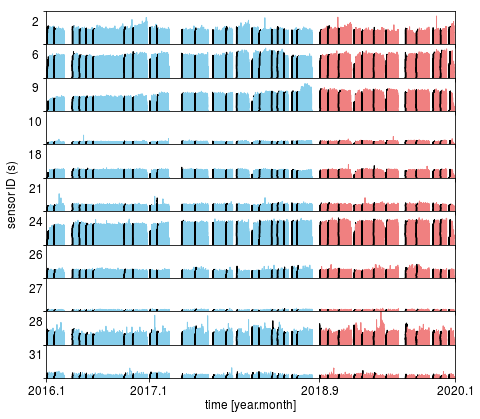

In [5]:
helper.plot_paper_data(train_sensor_data, test_sensor_data, n_samples_ic)

# Set up and fit model

In [6]:
edmd, n_samples_ic = helper.setup_basic_edmd()
# This can take a while... 
edmd.fit(train_sensor_data, {"dmd__store_system_matrix": True})

Model: 
 EDMDPositiveSensors(dict_steps=[('takens', TSCTakensEmbedding(delays=168)),
                                ('laplace',
                                 DiffusionMaps(dist_kwargs={'cut_off': inf},
                                               kernel=GaussianKernel(epsilon=median(Distance)*1.0),
                                               n_eigenpairs=500))],
                    dmd_model=DMDFull(is_diagonalize=True),
                    include_id_state=False, sort_koopman_triplets=True,
                    verbose=True)
[Pipeline] ............ (step 1 of 3) Processing takens, total=   0.3s
[Pipeline] ........... (step 2 of 3) Processing laplace, total= 9.5min
[Pipeline] ............... (step 3 of 3) Processing dmd, total=   1.3s


EDMDPositiveSensors(dict_steps=[('takens', TSCTakensEmbedding(delays=168)),
                                ('laplace',
                                 DiffusionMaps(dist_kwargs={'cut_off': inf},
                                               kernel=GaussianKernel(epsilon=2329526347.5),
                                               n_eigenpairs=500))],
                    dmd_model=DMDFull(is_diagonalize=True),
                    include_id_state=False, sort_koopman_triplets=True,
                    verbose=True)

# Reconstruct data


If `use_cache=False` the model computes the data again and overwrites existing cache in the .csv file (this may take a while).

### Reconstruct training data

In [7]:
if not use_cache:
    (
        X_reconstruct_train,
        X_windows_train,
        X_latent_train,
        X_latent_interp_train,
        X_eigfunc_train,
    ) = helper.reconstruct_prediction_horizon(
        edmd, train_sensor_data, prefix="train", interp_min_values=None
    )

    X_reconstruct_train.to_csv("X_reconstruct_train.csv")
    X_windows_train.to_csv("X_windows_train.csv")
    X_latent_train.to_csv("X_latent_train.csv")
else:
    X_reconstruct_train = TSCDataFrame.from_csv(
        "X_reconstruct_train.csv", parse_dates=True
    )
    X_windows_train = TSCDataFrame.from_csv("X_windows_train.csv", parse_dates=True)
    X_latent_train = TSCDataFrame.from_csv("X_latent_train.csv", parse_dates=True)

score train: -0.031872316753674884


### Reconstruct test data

In [8]:
if not use_cache:
    (
        X_reconstruct_test,
        X_windows_test,
        X_latent_test,
        X_latent_interp_test,
        X_eigfunc_test,
    ) = helper.reconstruct_prediction_horizon(
        edmd, test_sensor_data, prefix="test", interp_min_values=30
    )

    X_reconstruct_test.to_csv("X_reconstruct_test.csv")
    X_windows_test.to_csv("X_windows_test.csv")
    X_latent_test.to_csv("X_latent_test.csv")
    X_latent_interp_test.to_csv("X_latent_interp_test.csv")
    X_eigfunc_test.to_csv("X_eigfunc_test.csv")

else:
    X_reconstruct_test = TSCDataFrame.from_csv("X_reconstruct_test.csv", parse_dates=True)
    X_windows_test = TSCDataFrame.from_csv("X_windows_test.csv", parse_dates=True)
    X_latent_test = TSCDataFrame.from_csv("X_latent_test.csv", parse_dates=True)
    X_latent_interp_test = TSCDataFrame.from_csv("X_latent_interp_test.csv", parse_dates=True)
    
    # pandas does not read complex values from csv
    # https://github.com/pandas-dev/pandas/issues/9379
    # first read strings and then cast to complex
    X_eigfunc_test = pd.read_csv("X_eigfunc_test.csv", index_col=[0, 1], header=[0], parse_dates=True)
    X_eigfunc_test = TSCDataFrame(X_eigfunc_test.astype(complex))

score test: -0.03906084158923439


# Model analysis

## Example week of time series

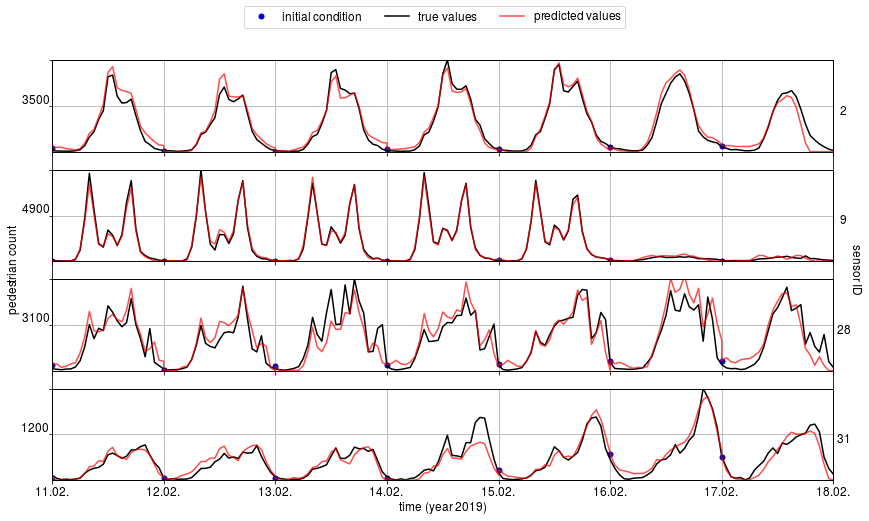

In [9]:
helper.plot_paper_week_timeseries(
    X_windows_test=X_windows_test, X_reconstruct_test=X_reconstruct_test
)

## Plot reconstruction of sensor test data

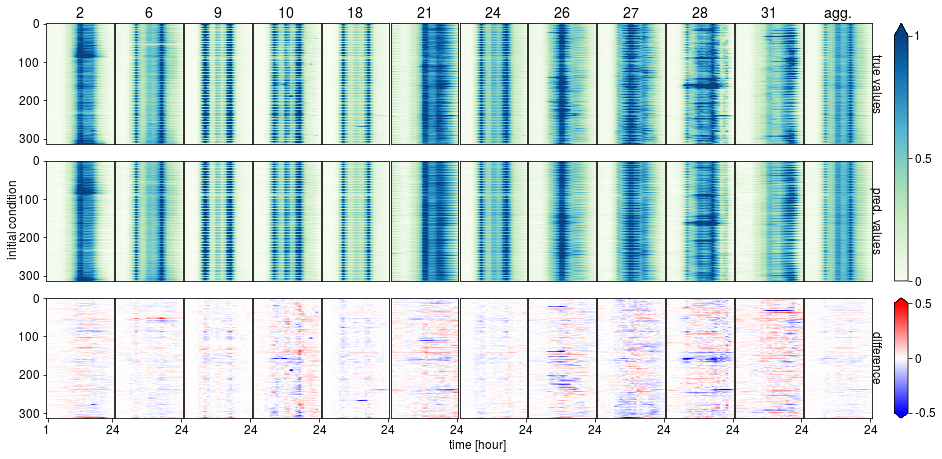

In [10]:
scale = helper.scale_sensors(X_windows=X_windows_train.loc[X_reconstruct_train.index, :])

helper.plot_paper_sensor_profile(
    scale=scale,
    X_windows_test=X_windows_test,
    X_reconstruct_test=X_reconstruct_test,
)

## Show error measures of table 

In [11]:
df = helper.plot_error_table(
    edmd=edmd,
    X_windows_train=X_windows_train,
    X_reconstruct_train=X_reconstruct_train,
    X_windows_test=X_windows_test,
    X_reconstruct_test=X_reconstruct_test,
)
df


MER on entire test set 16.982043558548757
EDMD score train = -0.031872316753674884
Naive score train = -0.0424159313376079
EDMD score test = -0.03906084158923439
Naive score test = -0.04684109289588103


training ($C_{\text{train}} = 622$)            \
   ID ($s$) $Q_{95\%}$                      mean $\pm$ std     RRMSE   
0         2       3116                        -8 $\pm$ 198   6.36 \%   
1         6       4048                        -3 $\pm$ 199   4.91 \%   
2         9       2805                        -2 $\pm$ 103   3.68 \%   
3        10        592                          0 $\pm$ 48   8.11 \%   
4        18       1540                         -1 $\pm$ 53   3.47 \%   
5        21       1410                        -2 $\pm$ 118    8.4 \%   
6        24       3970                        -2 $\pm$ 138   3.48 \%   
7        26       1629                        -1 $\pm$ 109   6.69 \%   
8        27        339                          0 $\pm$ 30   8.98 \%   
9        28       2662                        -4 $\pm$ 293  11.01 \%   
10       31        719                         -2 $\pm$ 81  11.33 \%   
11     agg.                                   -3 $\pm$ 171   6.95 \%   

             test ($C_{\text{test}} = 314$)                      
    RRMSE(b)                 mean $\pm$ std     RRMSE  RRMSE(b)  
0    8.69 \%                  -11 $\pm$ 204   6.55 \%   7.06 \%  
1    6.82 \%                    1 $\pm$ 254   6.28 \%   8.03 \%  
2    4.54 \%                   -6 $\pm$ 146    5.2 \%   5.83 \%  
3   10.34 \%                    -4 $\pm$ 57   9.62 \%  11.46 \%  
4    4.25 \%                     6 $\pm$ 74   4.81 \%    5.5 \%  
5   11.82 \%                   -9 $\pm$ 130   9.27 \%  11.51 \%  
6    4.65 \%                    8 $\pm$ 170   4.29 \%   5.11 \%  
7    8.24 \%                    4 $\pm$ 168  10.29 \%  12.08 \%  
8   11.64 \%                     4 $\pm$ 35   10.3 \%  11.88 \%  
9   16.25 \%                    1 $\pm$ 350  13.16 \%  17.99 \%  
10  14.57 \%                   -10 $\pm$ 95  13.26 \%   15.7 \%  
11   9.26 \%                   -1 $\pm$ 207   8.46 \%   10.2 \%

## Plot diffusion map coordinates on time-delayed data (dictionary of EDMD)  

Smallest DMAP eigenvalue = 1.6578957833468522e-05


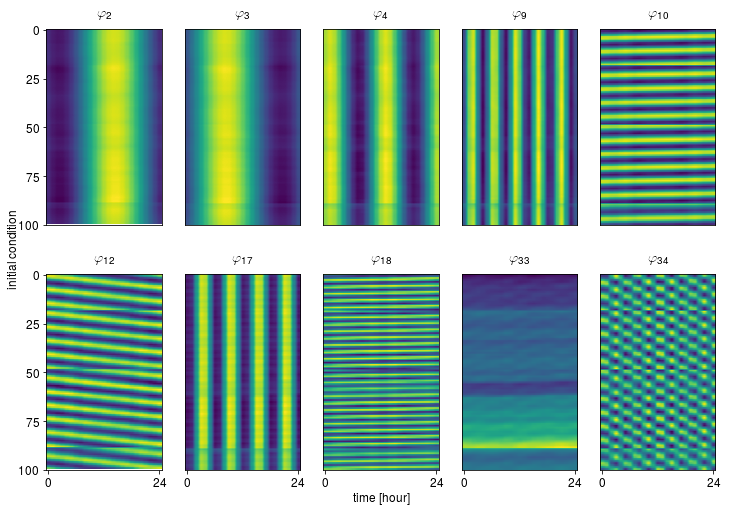

In [12]:
helper.plot_paper_dmap_selection(
    edmd,
    X_latent_test=X_latent_test,
)

## Plot saisonal diffusion map time series

In [13]:
helper.plot_timeseries_dmap(
    sensor_str="sensor_2_counts",
    dmap_idx=33,
    X_windows_train=X_windows_train,
    X_windows_test=X_windows_test.loc[X_reconstruct_test.index, :],
    X_latent_train=X_latent_train,
    X_latent_test=X_latent_test,
)

RuntimeError: latex was not able to process the following string:
b'sensor_2_counts'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/daniel/.cache/matplotlib/tex.cache/1578337b134ca725493d940285b75226.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 84 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texmf/tex/latex/tex-gyre/tgheros.sty
(/usr/share/texlive/texmf-dist/tex/latex/oberdiek/kvoptions.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ltxcmds.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/kvsetkeys.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/infwarerr.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/etexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifluatex.sty)))))
(/usr/share/texlive/texmf-dist/tex/latex/sansmath/sansmath.sty)
(/usr/share/texlive/texmf-dist/tex/latex/siunitx/siunitx.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/expl3.sty
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/expl3-code.tex)
(/usr/share/texlive/texmf-dist/tex/latex/l3kernel/l3dvips.def))
(/usr/share/texlive/texmf-dist/tex/latex/l3packages/xparse/xparse.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/tools/array.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3packages/l3keys2e/l3keys2e.sty)
(/usr/share/texlive/texmf-dist/tex/latex/translator/translator.sty))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 1578337b134ca725493d940285b75226.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

(/usr/share/texlive/texmf-dist/tex/latex/translator/translator-basic-dictionary
-English.dict)
(/usr/share/texlive/texmf-dist/tex/latex/siunitx/siunitx-abbreviations.cfg)
(/usr/share/texmf/tex/latex/tex-gyre/ot1qhv.fd)

LaTeX Font Warning: Font shape `OT1/qhv/m/sl' in size <10> not available
(Font)              Font shape `OT1/qhv/m/it' tried instead on input line 14.


LaTeX Font Warning: Font shape `OT1/qhv/m/sl' in size <7> not available
(Font)              Font shape `OT1/qhv/m/it' tried instead on input line 14.


LaTeX Font Warning: Font shape `OT1/qhv/m/sl' in size <5> not available
(Font)              Font shape `OT1/qhv/m/it' tried instead on input line 14.

! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily sensor_
                       2_counts}
No pages of output.
Transcript written on 1578337b134ca725493d940285b75226.log.




<Figure size 1008x554.4 with 2 Axes>

## Koopman eigenfunctions

Largest Koopman eigenvalue 1.0005339100598134


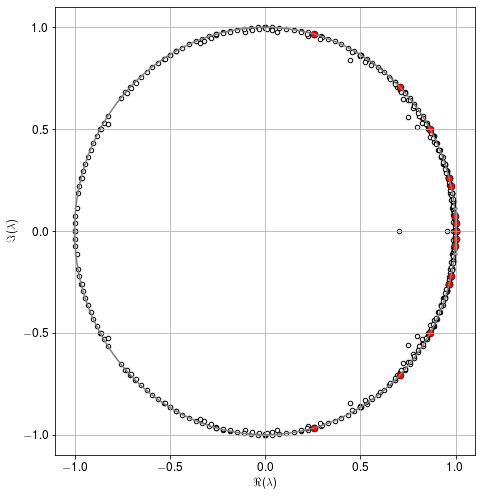

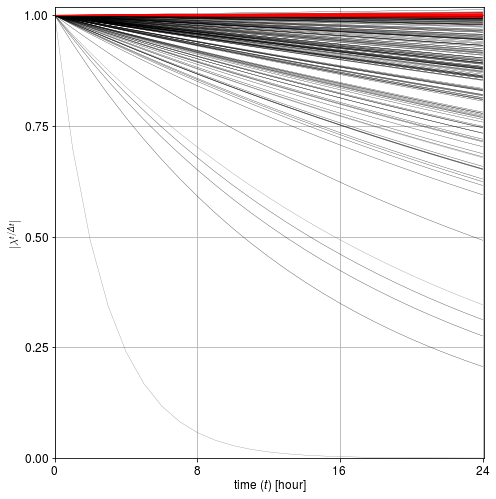

In [14]:
paper_selection = np.array([1, 4, 6, 8, 14]) # set in "select_plot" parameter below to obtain paper selection 
selection = np.arange(20)

helper.plot_paper_koop_eigval(
    edmd=edmd,
    select_plot=selection,
)

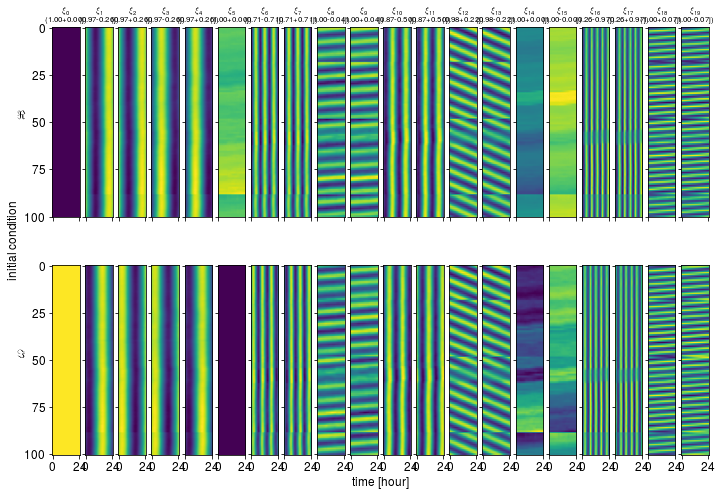

In [15]:
helper.plot_paper_koop_eigfunc(
    edmd=edmd,
    selection=selection,
    X_eigfunc_test=X_eigfunc_test,
)